#### First, I import my packages and the dataset.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
%matplotlib inline

dataset = pd.read_csv('US Retail 2009-2019 Month End.csv')

#### Then I set the month as the index. This can be done when importing the dataset, but I am doing it here.

In [8]:
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.set_index('Month', inplace=True)

#### Next, the frequency is set ('M' for month-end) and the data is split between training and tests sets.

In [9]:
dataset.index.freq = 'M'
train, test = dataset.iloc[:107, 0], dataset.iloc[106:, 0]

#### The training set is modeled. Information about the parameters can be found [here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html).

In [10]:
model = ExponentialSmoothing(train, trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()

#### I use the predict method with the beginning and end of the test index to choose the period being predicted. We lay our predictions over our test so we can compare the two later.

In [11]:
pred = model.predict(start=test.index[0], end=test.index[-1])

C:\Users\Grego\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


#### The training set comprises all but the last year's data (up until the end of 2017). The test set makes up 2018, which the predicted values are layed over for comparison.

C:\Users\Grego\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


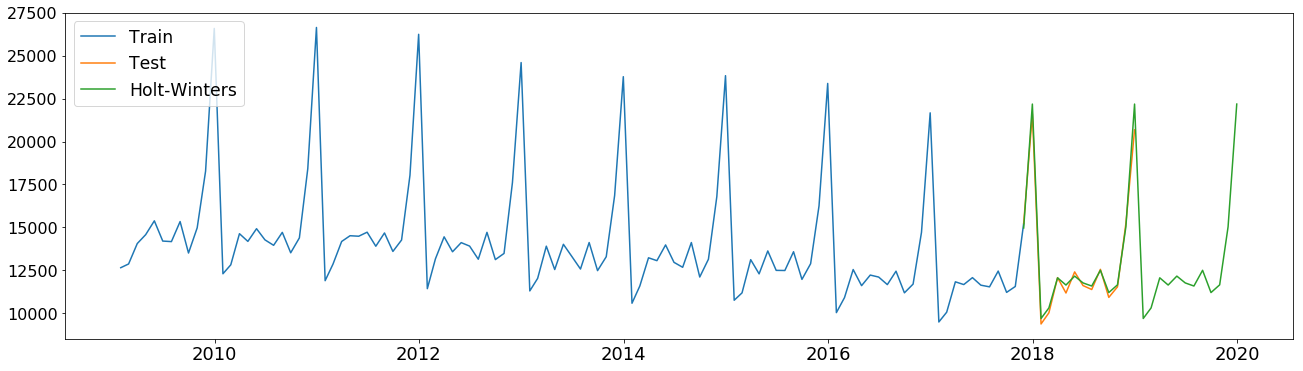

In [12]:
plt.figure(figsize=(22, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

#### The model did a good job of predicted forward a year. To utilize all the data to forecast sales for 2019, I am going to reset the training dataset to be made of all the data (up until the end of 2018) and stop using the test dataset.

#### This is nearly the same code as earlier, except forecast is used in place of test.

In [13]:
dataset.index.freq = 'M'
train, forecast = dataset.iloc[:119, 0],  dataset.iloc[118:, 0]
model = ExponentialSmoothing(train, trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
pred = model.predict(start=forecast.index[0], end=forecast.index[-1])

#### This is just a simple combining of the training and with the predicted forecast. I want a single line so I can roll it up into quarterly amounts.

In [14]:
df1 = pd.DataFrame(train, index=train.index, columns=['Sales'])
df2 = pd.DataFrame(pred, index=pred.index, columns=['Sales'])
df2.index.names = ['Month']
df2 = df2[1:]
df3 = df1.append(df2)

result = df3.resample('Q', convention='end').sum()

#### Here we plot the results of combining the training and the forecast. We have also annotated the amounts for each quarter.

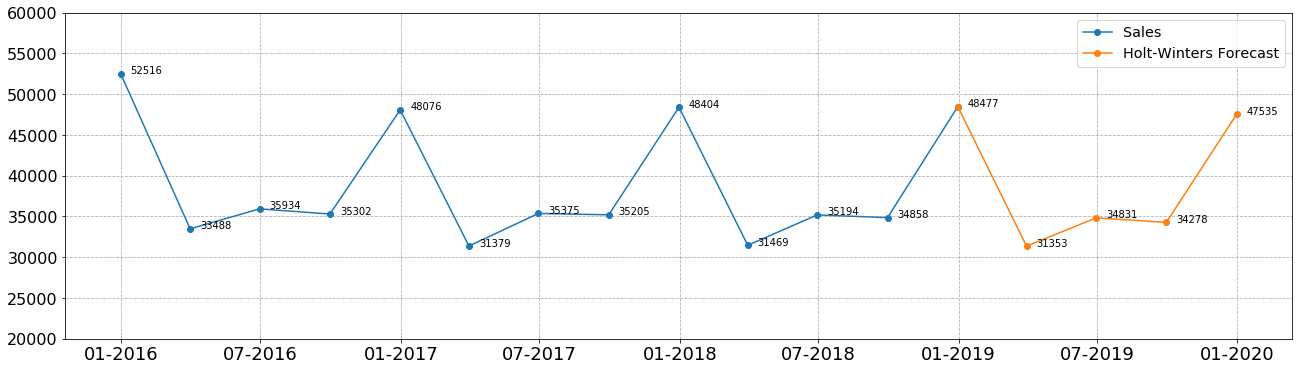

In [15]:
import matplotlib.dates as dates

plt.figure(figsize=(22,6))
plt.plot(result.index[27:40], result[27:40], label='Sales', marker='o')
plt.plot(result.index[39:44], result[39:44], label='Holt-Winters Forecast', marker='o')
plt.legend(loc='best', fontsize='x-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.grid(which='major', axis='both', linestyle='--')
plt.ylim(bottom=20000, top=60000)

A = pd.Series(result.index[27:])
B = pd.Series(result.Sales[27:])

for i,j in zip(A,B):
    ax.annotate('%s' %round(j), xy=(i,j), xytext=(10, 0), textcoords='offset points')
    
myFmt = dates.DateFormatter('%m-%Y')
ax.xaxis.set_major_formatter(myFmt)

plt.show()

#### And here we have it, our Q1 through Q4 forecast.